# WISDM HAR
- 정적, 동적 활동을 분리하여 학습

1.  동적 활동(Dynamic Activities) 모델: 'Walking', 'Jogging', 'Upstairs', 'Downstairs'
2.  정적 활동(Static Activities) 모델: 'Sitting', 'Standing'


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
def load_and_preprocess_data(file_path):
    """WISDM HAR 데이터 로드 및 전처리"""
    df = pd.read_csv(file_path)

    df['x-axis'] = df['x-axis'].astype('float32')
    df['y-axis'] = df['y-axis'].astype('float32')
    df['z-axis'] = df['z-axis'].astype('float32')

    return df

### PyTorch 데이터셋 클래스 만들기

- **`Dataset`**: 전체 데이터의 위치와 하나의 데이터를 가져오는 방법(`__getitem__`)을 정의한 클래스. 일종의 데이터 명세서.
- **`DataLoader`**: `Dataset`에서 정의한 방법을 사용해, 실제로 데이터를 배치 단위로 묶고, 섞어주고(shuffle), 병렬로 불러오는 역할을 함

### `WISDMDataset` 클래스

- `torch.utils.data.Dataset`을 상속받는 클래스
- 상속을 받으면 PyTorch의 데이터 처리 파이프라인과 호환됨

1.  **`__init__(self, ...)`**: 초기화 함수

2.  **`__len__(self)`**:
    - 데이터셋에 포함된 총 샘플(윈도우)의 개수를 반환
    - `DataLoader`가 전체 데이터를 몇 개의 배치로 나눌지 계산할 때 사용

3.  **`__getitem__(self, idx)`**:
    - `idx`(인덱스) 번호에 해당하는 데이터 샘플 하나를 반환하는 함수. `DataLoader`가 배치 데이터를 구성할 때 내부적으로 이 함수를 호출함
    - DataLoader는 batch_size만큼 idx를 무작위로 뽑아 __getitem__을 batch_size만큼 호출, 이것을 미니 배치로 만들어 모델에 전달
    - 무작위로 뽑아서 호출하면 순서가 섞이는 거 아닌가? -> 윈도우 '내부'의 순서는 섞이면 안 되지만, 윈도우 간의 순서는 독립적이므로 섞어도 됨 (훈련 시에만, 검증/테스트 시에는 동일한 순서로 평가해야 결과의 일관성을 유지할 수 있기 때문에 `shuffle=False`)
    - 반환되는 데이터는 **텐서(Tensor)** 형태여야 함
    - 텐서: PyTorch에서 사용하는 다차원 배열, GPU 연산에 최적화되어 있음
    - `transpose(0, 1)`는 데이터의 차원 순서를 바꾸는 역할을 함. -> PyTorch의 1D 컨볼루션 레이어(`Conv1d`)는 `(배치크기, 채널, 길이)` 형태의 입력을 기대하기 때문에, `(길이, 채널)` 형태의 윈도우를 `(채널, 길이)`로 바꿔줌
    - TensorFlow는 (batch_size, time_step, n_features) 형태
    - WISDM data에서 채널은 x, y, z의 3개



In [4]:
class WISDMDataset(Dataset):
    def __init__(self, data, window_size=128, scaler=None):
        self.window_size = window_size
        self.data = []
        self.labels = []

        self.activity_encoder = LabelEncoder()

        # sliding window
        for user in data['user'].unique():
            user_data = data[data['user'] == user]
            sensor_data = user_data[['x-axis', 'y-axis', 'z-axis']].values
            activity_labels = user_data['activity'].values

            for i in range(0, len(sensor_data) - window_size + 1, window_size // 2):
                window = sensor_data[i:i + window_size]
                labels_in_window = activity_labels[i:i + window_size]

                if len(window) == window_size:
                    # 최빈값을 label로
                    # Counter(labels_in_window).most_common(1) -> [('Walking', 120)]과 같은 형태
                    most_common_label = Counter(labels_in_window).most_common(1)[0][0]

                    self.data.append(window)
                    self.labels.append(most_common_label)

        # label encoding
        self.encoded_labels = self.activity_encoder.fit_transform(self.labels)

        # scaling
        self.data = np.array(self.data)
        original_shape = self.data.shape
        if scaler is None:
            self.scaler = StandardScaler()
            self.data = self.scaler.fit_transform(self.data.reshape(-1, 3)).reshape(original_shape) # StandardSclaer는 2차원 입력을 받음
        else:
            self.scaler = scaler
            self.data = self.scaler.transform(self.data.reshape(-1, 3)).reshape(original_shape)

        print(f"Dataset created with {len(self.data)} samples.")
        print(f"... Activity distribution: {Counter(self.labels)}\n") # Counter: 각 항목이 몇 개씩 들어 있는지 세서 딕셔너리 형태로 알려줌

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # [길이 128, 채널 3] 형태의 데이터를 [채널 3, 길이 128]로 변환
        data_tensor = torch.FloatTensor(self.data[idx]).transpose(0, 1)
        label_tensor = torch.LongTensor([self.encoded_labels[idx]])[0]
        return data_tensor, label_tensor

SE Block
- Squeeze: Global Average Polling을 통해 각 채널의 정보를 하나의 숫자로 압축
- Excitation: 채널 간의 연관성을 학습, 2개의 병목 FC 레이어로 이루어짐, Sigmoid를 통해 각 채널의 중요도 가중치를 생성

In [5]:
class SEBlock1D(nn.Module):
    """ 1D 데이터(시계열)를 위한 Squeeze-and-Excitation (SE) 블록 """
    def __init__(self, channels, reduction_ratio=16):
        """
        Args:
            channels (int): 입력 특징 맵의 채널 수 (C)
            reduction_ratio (int): Excitation 단계의 병목 구조에서 차원을 얼마나 줄일지에 대한 비율 (r)
        """
        super(SEBlock1D, self).__init__()

        # Squeeze: 입력 (B, C, L) -> 출력 (B, C, 1)
        self.gap = nn.AdaptiveAvgPool1d(1)

        # Excitation
        self.fc_stack = nn.Sequential(
            # FC 1: 채널 차원을 C -> C/r 로 압축 (병목). 1x1 Conv 사용
            nn.Conv1d(channels, channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            # FC 2: 채널 차원을 C/r -> C 로 다시 복원
            nn.Conv1d(channels // reduction_ratio, channels, kernel_size=1, bias=False),
            # Sigmoid: 0~1 사이의 값으로 채널별 중요도 가중치를 생성
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (B, C, L)

        # Squeeze
        x_squeeze = self.gap(x)  # shape: (B, C, 1)

        # Excitation
        excitation = self.fc_stack(x_squeeze) # shape: (B, C, 1) (채널별 가중치)

        # 3. Rescale (재조정)
        # 원본 입력 x (B, C, L)에 가중치 excitation (B, C, 1)을 채널별로 곱함
        # (B, C, 1)이 (B, C, L)로 브로드캐스팅되어 적용됨
        return x * excitation

SE-ResNet Block
- ResNet Block에 SE Block을 통합

In [6]:
class SEResNetBlock1D(nn.Module):
    """ 1D ResNet 블록에 Squeeze-and-Excitation (SE) 블록을 통합한 모듈 """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, reduction_ratio=16):
        super(SEResNetBlock1D, self).__init__()

        # ResNet 블록
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # SE 블록.
        self.se_block = SEBlock1D(out_channels, reduction_ratio)

        # Downsample 레이어
        # Stride가 2 이상이거나 입력/출력 채널 수가 다를 때, 원본 x의 shape을 F(x)의 shape과 맞춰주기 위한 1x1 Conv 레이어
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        residual = x  # 원본 입력(x) 저장

        # F(x) 계산 시작
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 특징 맵(out)이 생성된 직후, SE 블록을 통과시켜 채널별 가중치를 재조정
        out = self.se_block(out)

        # Downsample 적용 (필요한 경우)
        if self.downsample is not None:
            residual = self.downsample(x)

        # Residual connection
        out += residual
        out = self.relu(out)

        return out

SENetHAR
- SEResNetBlock1D를 여러 층으로 쌓아 특징을 추출

Stem
- 모델의 본체가 시작되기 전 입력 데이터를 효율적으로 처리하는 초기 conv/pooling block
- 채널 수가 적은 초기 단계에서 큰 커널을 사용하여 넓은 패턴을 파악하고, stride=2를 사용하여 시퀀스를 줄임 -> 계산량을 줄임

In [7]:
class SENetHAR(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(SENetHAR, self).__init__()

        # 1. Stem (초기 특징 추출기)
        # 입력: (B, 3, 128)
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) # (B, 64, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1) # (B, 64, 32)

        # 2. Layers: SE-ResNet 블록 스택
        # (in_channels, out_channels, blocks, stride)
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)  # (B, 64, 32)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2) # (B, 128, 16)

        # 3. Classifier (분류기)
        # (B, 128, 1) -> 시퀀스 전체를 요약하는 특징 벡터 생성
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)

        # FC 레이어
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        """ SEResNetBlock1D 블록을 여러 개 쌓는 헬퍼 함수 """
        layers = []
        # 첫 번째 블록은 stride와 채널 변경(downsample)을 적용
        layers.append(SEResNetBlock1D(in_channels, out_channels, stride=stride))
        # 나머지 블록들은 채널과 길이를 그대로 유지
        for _ in range(1, blocks):
            layers.append(SEResNetBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers) # 리스트를 nn.Sequential로 언패킹

    def forward(self, x):
        # 1. Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # 2. Layers
        x = self.layer1(x)
        x = self.layer2(x)

        # 3. Classifier
        x = self.global_pool(x) # (B, 128, 1)

        # .squeeze()를 사용해 (B, 128, 1) -> (B, 128)으로 차원 축소
        # (FC 레이어 입력에 맞추기 위함)
        x = x.squeeze(-1)
        x = self.dropout(x)

        output = self.classifier(x) # (B, num_classes)
        return output

In [8]:
def train_model(model, train_loader, val_loader, num_epochs, model_save_path, class_weights=None, patience=15):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5) # 손실이 개선되지 않으면 학습률을 낮춤

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf') # 가장 좋았던 검증 손실을 저장하는 변수
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # 훈련 단계
        model.train()
        train_loss = 0.0
        correct_train, total_train = 0, 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad() # 이전 그래디언트 초기화
            outputs = model(data) # 순전파
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 그래디언트 폭주 방지를 위한 gradient clipping
            optimizer.step() # 가중치 업데이트
            train_loss += loss.item()

            # 훈련 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # 검증 단계
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        scheduler.step(avg_val_loss)

        # 최고 성능 모델 저장 (Early Stopping 기준)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path) # 지정된 경로에 모델 저장
            early_stop_counter = 0  # 카운터 초기화
        else:
            early_stop_counter += 1 # 성능이 개선되지 않으면 카운터 증가

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break # 훈련 중단

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f},  Val Accuracy: {val_accuracy:.4f}')

    return history

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [10]:
# 모델 평가
def evaluate_model(model, test_loader, dataset):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nAccuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(classification_report(all_labels, all_preds, target_names=dataset.activity_encoder.classes_, digits=4))
    plot_confusion_matrix(all_labels, all_preds, dataset.activity_encoder.classes_)

In [11]:
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch'); ax1.legend(); ax1.grid(True)

    ax2.plot(history['train_acc'], label='Training Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='green')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(True)

    plt.show()



### `run_experiment` 함수의 역할
parameter
- `activity_type`: "Dynamic" 또는 "Static"
- `activities`: 해당 실험에 사용할 활동 목록
- `full_df`: 전체 데이터프레임
- `num_epochs`: 훈련 에포크 수

함수 동작 과정
1.  주어진 활동 목록으로 원본 데이터를 필터링
2.  피험자 ID를 기준으로 훈련/검증/테스트 데이터프레임으로 나눔
3.  데이터셋, 데이터로더 생성(스케일러 데이터 유출 방지 로직 포함)
4.  분류할 클래스 수에 맞춰 모델을 생성
5.  모델을 훈련하고, 최고 성능 모델을 저장
6.  저장된 최고 모델로 최종 평가를 수행하고, 훈련 과정을 시각화


### STARTING EXPERIMENT FOR: DYNAMIC ACTIVITIES ###
Filtered data for Dynamic activities. Total rows: 978132

Creating datasets...
Dataset created with 11642 samples.
... Activity distribution: Counter({'Walking': 5026, 'Jogging': 4007, 'Upstairs': 1464, 'Downstairs': 1145})

Dataset created with 1952 samples.
... Activity distribution: Counter({'Walking': 846, 'Jogging': 610, 'Upstairs': 276, 'Downstairs': 220})

Dataset created with 1637 samples.
... Activity distribution: Counter({'Walking': 648, 'Jogging': 631, 'Upstairs': 179, 'Downstairs': 179})

Class Weights for Dynamic: ['Downstairs' 'Jogging' 'Upstairs' 'Walking']
Calculated weights: [2.5419214  0.7263539  1.9880464  0.57908875]
Model for Dynamic created with 4 output classes.
Total parameters: 246,276

--- Training Dynamic Model ---
Epoch [1/100], Train Loss: 0.6287, Val Loss: 0.8437, Train Accuracy: 0.8284,  Val Accuracy: 0.7900
Epoch [2/100], Train Loss: 0.3035, Val Loss: 1.1138, Train Accuracy: 0.9302,  Val Accuracy: 0.76

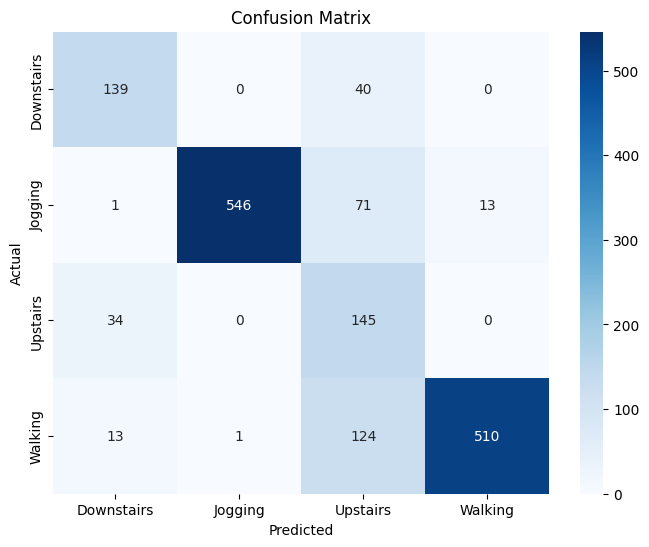

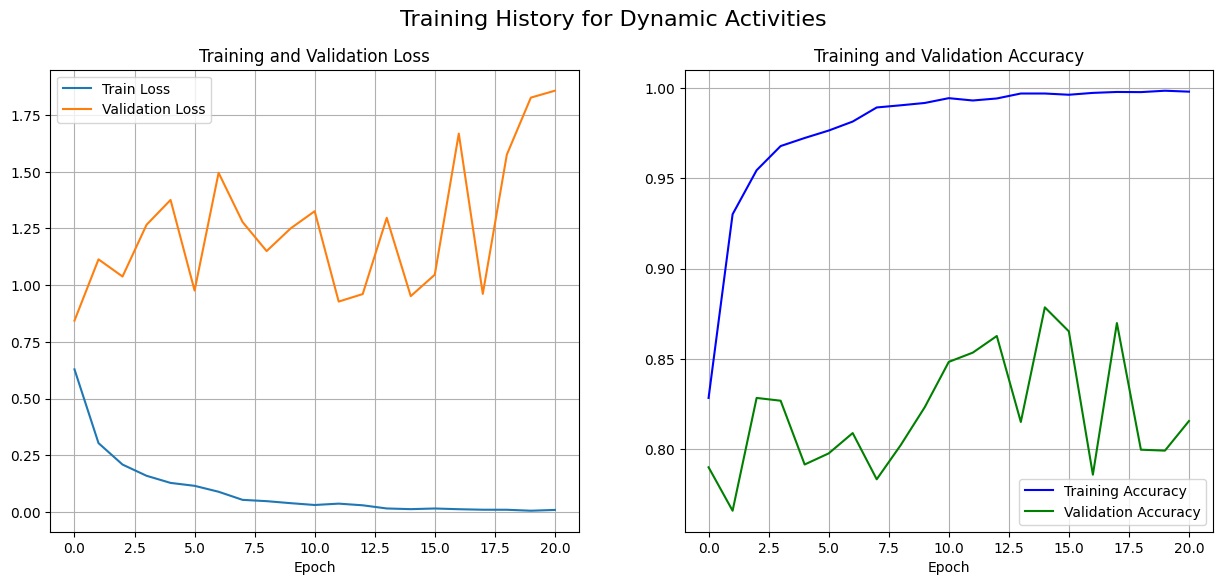



### STARTING EXPERIMENT FOR: STATIC ACTIVITIES ###
Filtered data for Static activities. Total rows: 108333

Creating datasets...
Dataset created with 1152 samples.
... Activity distribution: Counter({'Sitting': 646, 'Standing': 506})

Dataset created with 276 samples.
... Activity distribution: Counter({'Sitting': 140, 'Standing': 136})

Dataset created with 226 samples.
... Activity distribution: Counter({'Sitting': 135, 'Standing': 91})

Class Weights for Static: ['Sitting' 'Standing']
Calculated weights: [0.89164084 1.1383399 ]
Model for Static created with 2 output classes.
Total parameters: 246,146

--- Training Static Model ---
Epoch [1/100], Train Loss: 0.2098, Val Loss: 0.5006, Train Accuracy: 0.9227,  Val Accuracy: 0.8261
Epoch [2/100], Train Loss: 0.0792, Val Loss: 1.0530, Train Accuracy: 0.9731,  Val Accuracy: 0.6848
Epoch [3/100], Train Loss: 0.0865, Val Loss: 0.7377, Train Accuracy: 0.9731,  Val Accuracy: 0.7935
Epoch [4/100], Train Loss: 0.0605, Val Loss: 0.5968, Train 

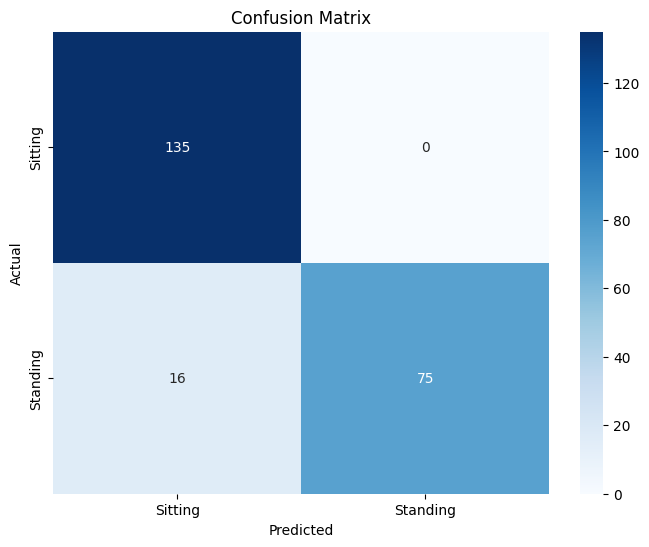

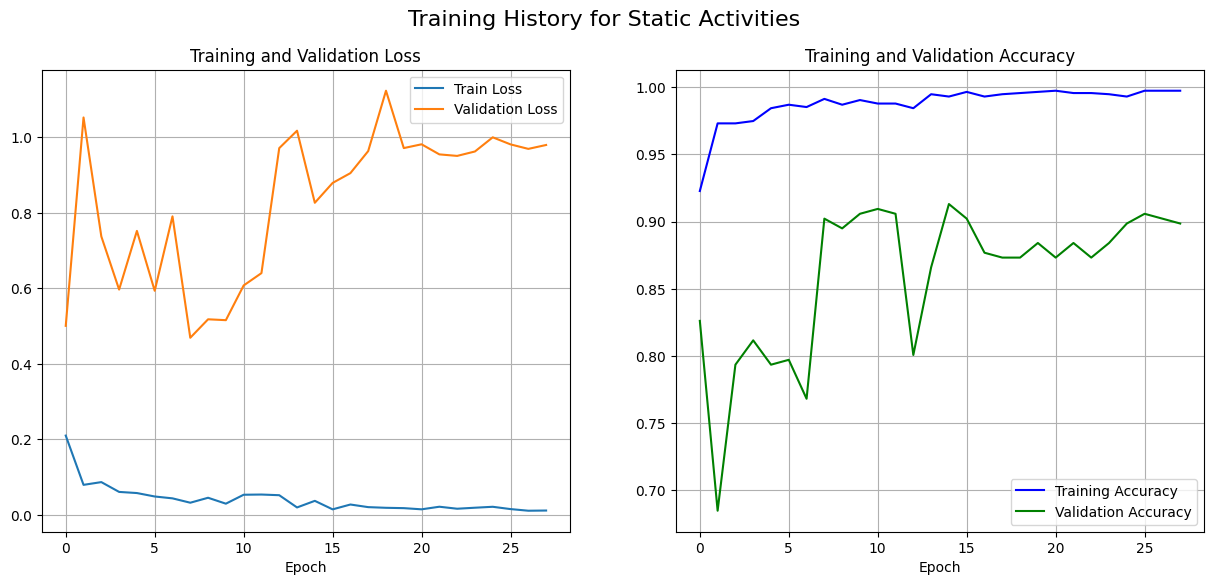

In [12]:
def run_experiment(activity_type, activities, full_df, num_epochs=30):
    print("="*60)
    print(f"### STARTING EXPERIMENT FOR: {activity_type.upper()} ACTIVITIES ###")
    print("="*60)

    # 1. 실험에 맞는 데이터만 필터링
    df = full_df[full_df['activity'].isin(activities)].copy()
    print(f"Filtered data for {activity_type} activities. Total rows: {len(df)}")

    # 2. 피험자 ID 기준으로 데이터프레임 분할
    train_df = df[df['user'] <= 28]
    val_df = df[(df['user'] > 28) & (df['user'] <= 32)]
    test_df = df[(df['user'] > 32) & (df['user'] <= 36)]

    # 3. 데이터셋 및 데이터로더 생성
    print("\nCreating datasets...")
    train_dataset = WISDMDataset(train_df, window_size=128)
    fitted_scaler = train_dataset.scaler
    val_dataset = WISDMDataset(val_df, window_size=128, scaler=fitted_scaler)
    test_dataset = WISDMDataset(test_df, window_size=128, scaler=fitted_scaler)

    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_dataset.encoded_labels),
        y=train_dataset.encoded_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    print(f"Class Weights for {activity_type}: {train_dataset.activity_encoder.classes_}")
    print(f"Calculated weights: {class_weights.cpu().numpy()}")
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 4. 모델 생성
    num_classes = len(activities)
    model = SENetHAR(
        num_classes=num_classes, input_channels=3
    ).to(device)
    print(f"Model for {activity_type} created with {num_classes} output classes.")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")

    # 5. 모델 훈련
    print(f"--- Training {activity_type} Model ---")
    model_save_path = f'best_model_{activity_type.lower()}.pth'
    history = train_model(model, train_loader, val_loader, num_epochs, model_save_path, class_weights, patience=20)

    # 6. 최종 평가 및 시각화
    print(f"\n--- Final Evaluation for {activity_type} Model ---")
    model.load_state_dict(torch.load(model_save_path))
    evaluate_model(model, test_loader, test_dataset)
    plot_training_history(history, f'Training History for {activity_type} Activities')
    print("\n")

if __name__ == '__main__':
    file_path = '/content/drive/MyDrive/AI_data/WISDM_HAR.csv'
    full_data = load_and_preprocess_data(file_path)

    # dynamic activities
    dynamic_activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
    run_experiment('Dynamic', dynamic_activities, full_data, num_epochs=100)

    # static activities
    static_activities = ['Sitting', 'Standing']
    run_experiment('Static', static_activities, full_data, num_epochs=100)